# CUDA - MANDELBROT

## GPU info

In [ ]:
!nvcc /content/devicequery.cu -o devicequery -run

./devicequery Starting...

 CUDA Device Query (Runtime API) version (CUDART static linking)

Detected 1 CUDA Capable device(s)

Device 0: "Tesla T4"
  CUDA Driver Version / Runtime Version          12.4 / 12.5
  CUDA Capability Major/Minor version number:    7.5
  Total amount of global memory:                 15095 MBytes (15828320256 bytes)
  (040) Multiprocessors, (064) CUDA Cores/MP:    2560 CUDA Cores
  GPU Max Clock rate:                            1590 MHz (1.59 GHz)
  Memory Clock rate:                             5001 Mhz
  Memory Bus Width:                              256-bit
  L2 Cache Size:                                 4194304 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(131072), 2D=(131072, 65536), 3D=(16384, 16384, 16384)
  Maximum Layered 1D Texture Size, (num) layers  1D=(32768), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(32768, 32768), 2048 layers
  Total amount of constant memory:               65536 bytes
  Total amount of shar

In [ ]:
!nvidia-smi

Wed Mar 19 11:02:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Compilation and runs

In [ ]:
!nvcc -O3 -arch=sm_75 /content/mandelbrot.cu -o mandelbrot

In [ ]:
!nvprof /content/mandelbrot 4

==22733== NVPROF is profiling process 22733, command: /content/mandelbrot 4
Time elapsed: 17.608 seconds.
<<2250 x 1500,4 x 4>>
Please specify the output file as a parameter.
==22733== Profiling application: /content/mandelbrot 4
==22733== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   98.69%  17.3671s         1  17.3671s  17.3671s  17.3671s  mandelbrot(int*)
                    1.31%  230.61ms         1  230.61ms  230.61ms  230.61ms  [CUDA memcpy DtoH]
      API calls:   99.16%  17.6022s         1  17.6022s  17.6022s  17.6022s  cudaMemcpy
                    0.80%  142.56ms         1  142.56ms  142.56ms  142.56ms  cudaMalloc
                    0.02%  3.5042ms         1  3.5042ms  3.5042ms  3.5042ms  cudaFree
                    0.01%  2.2063ms         1  2.2063ms  2.2063ms  2.2063ms  cudaLaunchKernel
                    0.00%  199.31us       114  1.7480us     192ns  77.891us  cuDeviceGetAttribute
                

In [ ]:
%%capture cap
ts = [1, 2, 4, 8, 16, 32, 64]

for t in ts:
  for i in range(10):
    print("----------------------------")
    print(f"Threads: {t} - iteration: {i+1}")
    ! ./mandelbrot {t} {t}.txt

In [ ]:
f = open("output.txt", "w")
print(cap, file=f)
f.close()

## Graphs

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def parse_file(filename):
    results = {}
    with open(filename, 'r') as file:
        content = file.read()
        blocks = content.split('----------------------------')

        for block in blocks:
            if not block.strip():
                continue

            thread_match = re.search(r'Threads: (\d+)', block)
            time_match = re.search(r'Time elapsed: ([\d\.]+) seconds.', block)

            if thread_match and time_match:
                threads = int(thread_match.group(1))
                time_elapsed = float(time_match.group(1))

                if threads not in results:
                    results[threads] = []
                results[threads].append(time_elapsed)

    return results

In [ ]:
def mean_time(data):
  df = pd.DataFrame([(t, time) for t, times in data.items() for time in times], columns=['Threads', 'Time'])
  df = df.sort_values('Threads')
  mean_times = df.groupby('Threads')['Time'].mean()
  for thread, mean_time in mean_times.items():
      print(f"Thread: {thread}, Tempo medio: {mean_time:.6f} secondi")

filename = "outputC.txt"
datac = parse_file(filename)
mean_time(datac)

Thread: 1, Tempo medio: 129.188400 secondi
Thread: 2, Tempo medio: 32.500440 secondi
Thread: 4, Tempo medio: 8.484970 secondi
Thread: 8, Tempo medio: 4.430039 secondi
Thread: 16, Tempo medio: 4.451864 secondi
Thread: 32, Tempo medio: 4.511525 secondi
Thread: 64, Tempo medio: 0.169628 secondi


In [ ]:
def plot_execution_time(data):
    df = pd.DataFrame([(t**2, time) for t, times in data.items() for time in times], columns=['Threads', 'Time'])
    df = df.sort_values('Threads')
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Threads', y='Time', data=df)
    plt.xlabel("Threads", fontsize=12)
    plt.ylabel("Time (s)", fontsize=12)
    plt.title("Execution Time per Threads", fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_speedup_efficiency(data):
    df = pd.DataFrame([(t**2, np.mean(times)) for t, times in data.items()], columns=['Threads', 'Time'])
    df = df.sort_values('Threads')

    T1 = df[df['Threads'] == min(df['Threads'])]['Time'].values[0]
    df['Speedup'] = T1 / df['Time']
    df['Efficiency'] = df['Speedup'] / df['Threads']

    print("Speedup:")
    print(df[['Threads', 'Speedup']])
    print("\nEfficiency:")
    print(df[['Threads', 'Efficiency']])

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Threads', y='Speedup', data=df, marker='o', linewidth=2, label="Measured Speedup")
    plt.plot(df['Threads'], df['Threads'], linestyle='--', color='black', label="Ideal Speedup")
    plt.xlabel("Threads (log scale)", fontsize=12)
    plt.ylabel("Speedup (T1/Tp) (log scale)", fontsize=12)
    plt.title("Speedup vs Threads", fontsize=14)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(df['Threads'].tolist(), df['Threads'].tolist())
    plt.yticks([1,2,3,5,8,12,20,32,52], [1,2,3,5,8,12,20,32,52])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(df['Threads'], df['Efficiency'], marker='s', label="Efficiency")
    plt.axhline(y=1, color='k', linestyle='--', label="Ideal Efficiency")
    plt.xlabel("Threads (log scale)", fontsize=12)
    plt.ylabel("Efficiency (log scale)", fontsize=12)
    plt.title("Efficiency vs Threads", fontsize=14)
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(df['Threads'].tolist(), df['Threads'].tolist())
    plt.yticks([1,0.8,0.6,0.4,0.2,0.1,0.03], [1,0.8,0.6,0.4,0.2,0.1,0.03])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

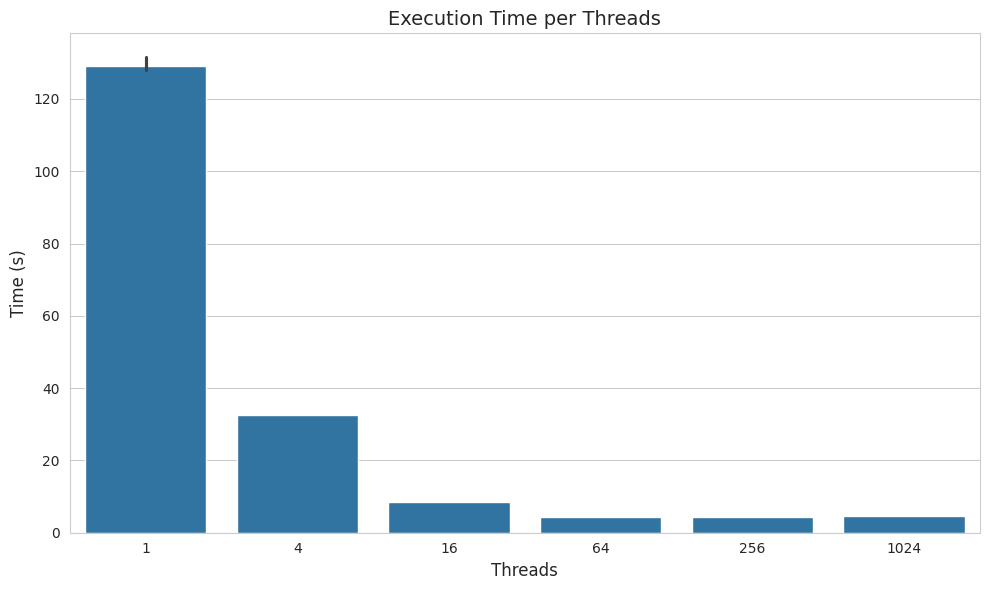

Speedup:
   Threads    Speedup
0        1   1.000000
1        4   3.974974
2       16  15.225558
3       64  29.161910
4      256  29.018946
5     1024  28.635195

Efficiency:
   Threads  Efficiency
0        1    1.000000
1        4    0.993743
2       16    0.951597
3       64    0.455655
4      256    0.113355
5     1024    0.027964


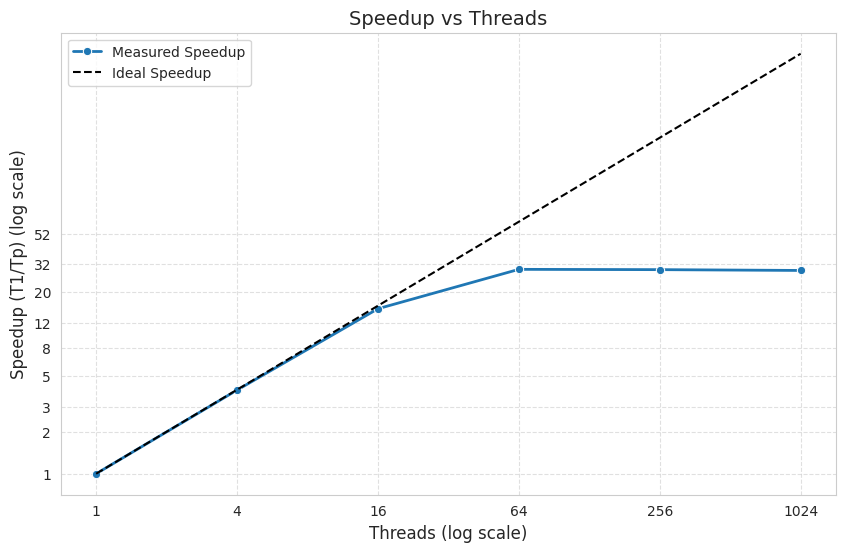

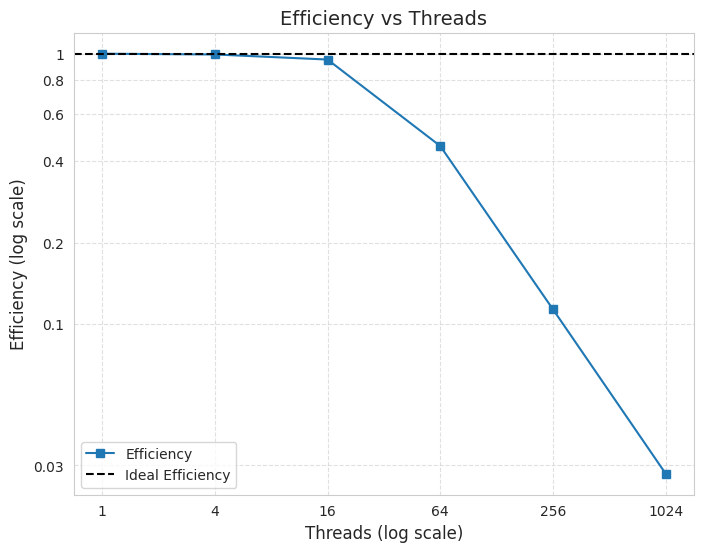

In [ ]:
filename = "output.txt"
data = parse_file(filename)
plot_execution_time(data)
plot_speedup_efficiency(data)